# DAT257x: Reinforcement Learning Explained

## Lab 7: Policy Gradient

### Exercise 7.3: Actor Critic

## Objectives
* Implement A3C-like N-step updating: $Q(s_t,a_t) = E[r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^n V(s_{t+n})]$
* Play around with different values of $n$. How does the value of $n$ affect the variance and performance of the algorithm?

## Success Criterion
The variance with n-step updates should be even smaller than that of Baselined Reinforce. A correct implementation will not solve the Cartpole domain faster or more frequently, but it should do so with less variance. 

In [1]:
import cntk as C
from cntk.layers import Sequential, Dense
from cntk.logging import ProgressPrinter
import numpy as np

import sys
if "../" not in sys.path:
    sys.path.append("../") 
    
import gym
from lib.running_variance import RunningVariance
from lib import plotting

np.random.seed(123)
C.cntk_py.set_fixed_random_seed(123)
C.cntk_py.force_deterministic_algorithms()

env = gym.make('CartPole-v0')

state_dim = env.observation_space.shape[0] # Dimension of state space
action_count = env.action_space.n # Number of actions
hidden_size = 128 # Number of hidden units
update_frequency = 20

# The policy network maps an observation to a probability of taking action 0 or 1.
observations = C.sequence.input_variable(state_dim, np.float32, name="obs")
W1 = C.parameter(shape=(state_dim, hidden_size), init=C.glorot_uniform(), name="W1")
b1 = C.parameter(shape=hidden_size, name="b1")
layer1 = C.relu(C.times(observations, W1) + b1)
W2 = C.parameter(shape=(hidden_size, action_count), init=C.glorot_uniform(), name="W2")
b2 = C.parameter(shape=action_count, name="b2")
layer2 = C.times(layer1, W2) + b2
output = C.sigmoid(layer2, name="output")

# Label will tell the network what action it should have taken.
label = C.sequence.input_variable(1, np.float32, name="label")
# return_weight is a scalar containing the discounted return. It will scale the PG loss.
return_weight = C.sequence.input_variable(1, np.float32, name="weight")
# PG Loss 
loss = -C.reduce_mean(C.log(C.square(label - output) + 1e-4) * return_weight, axis=0, name='loss')

# Build the optimizer
lr_schedule = C.learning_rate_schedule(lr=0.1, unit=C.UnitType.sample) 
m_schedule = C.momentum_schedule(0.99)
vm_schedule = C.momentum_schedule(0.999)
optimizer = C.adam([W1, W2], lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)

# Create a buffer to manually accumulate gradients
gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

# Define the critic network
critic = Sequential([
    Dense(128, activation=C.relu, init=C.glorot_uniform()),
    Dense(1, activation=None, init=C.glorot_uniform(scale=.01))
])(observations)

# Define target and Squared Error Loss Function, adam optimizier, and trainer for the Critic.
critic_target = C.sequence.input_variable(1, np.float32, name="target")
critic_loss = C.squared_error(critic, critic_target)
critic_lr_schedule = C.learning_rate_schedule(lr=0.1, unit=C.UnitType.sample) 
critic_optimizer = C.adam(critic.parameters, critic_lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)
critic_trainer = C.Trainer(critic, (critic_loss, None), critic_optimizer)

def discount_rewards(r, gamma=0.999):
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Now you need to implement the function that computes n-step update targets:

In [21]:
# TODO: Create a function that returns an array of n-step targets, one for each timestep:
# target[t] = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... + \gamma^n V(s_{t+n})
# Where r_t is given by episode reward (epr) and V(s_n) is given by the baselines.
def compute_n_step_targets(epr, baselines, gamma=0.999, n=15):
    """ Computes a n_step target value. """
    n_step_targets = np.zeros_like(epr)
    
    ## Code here
#     for k in range(len(n_step_targets)):
#         for t in range(n):
#             target_tmp = 0
#             for i in range(t):
#                 target_tmp += np.power(gamma, i) * epr[i]
#             target_tmp += np.power(gamma, t+1) * baselines[t]
#             n_step_targets[t] = target_tmp
#     print("n_step_targets = ", n_step_targets)    

    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + GAMMA * Qval
        Qvals[t] = Qval
    
    return n_step_targets

The main loop is the same and should not need modification except for trying different values of $n$.

In [22]:
running_variance = RunningVariance()
reward_sum = 0

max_number_of_episodes = 500

stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(max_number_of_episodes),
    episode_rewards=np.zeros(max_number_of_episodes),
    episode_running_variance=np.zeros(max_number_of_episodes))

for episode_number in range(max_number_of_episodes):
    states, rewards, labels = [],[],[]
    done = False
    observation = env.reset()
    t = 1
    while not done:
        state = np.reshape(observation, [1, state_dim]).astype(np.float32)
        states.append(state)

        # Run the policy network and get an action to take.
        prob = output.eval(arguments={observations: state})[0][0][0]
        # Sample from the bernoulli output distribution to get a discrete action
        action = 1 if np.random.uniform() < prob else 0

        # Pseudo labels to encourage the network to increase
        # the probability of the chosen action. This label will be used
        # in the loss function above.
        y = 1 if action == 0 else 0  # a "fake label"
        labels.append(y)

        # step the environment and get new measurements
        observation, reward, done, _ = env.step(action)
        reward_sum += float(reward)

        # Record reward (has to be done after we call step() to get reward for previous action)
        rewards.append(float(reward))
        
        stats.episode_rewards[episode_number] += reward
        stats.episode_lengths[episode_number] = t
        t += 1

    # Stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(states)
    epl = np.vstack(labels).astype(np.float32)
    epr = np.vstack(rewards).astype(np.float32)

    # Compute the discounted reward backwards through time.
    discounted_epr = discount_rewards(epr)

    # Train the critic to predict the discounted reward from the observation
    critic_trainer.train_minibatch({observations: epx, critic_target: discounted_epr})
    baseline = critic.eval({observations: epx})
    
    # Compute n-step targets
    n_step_targets = compute_n_step_targets(epr, baseline[0])

    # Compute the baselined returns: A = n_step_targets - b(s). Weight the gradients by this value.
    baselined_returns = n_step_targets - baseline
    
    # Keep a running estimate over the variance of of the discounted rewards
    for r in baselined_returns:
        running_variance.add(r[0,0])

    # Forward pass
    arguments = {observations: epx, label: epl, return_weight: baselined_returns}
    state, outputs_map = loss.forward(arguments, outputs=loss.outputs,
                                      keep_for_backward=loss.outputs)

    # Backward pass
    root_gradients = {v: np.ones_like(o) for v, o in outputs_map.items()}
    vargrads_map = loss.backward(state, root_gradients, variables=set([W1, W2]))

    for var, grad in vargrads_map.items():
        gradBuffer[var.name] += grad

    # Only update every 20 episodes to reduce noise
    if episode_number % update_frequency == 0:
        grads = {W1: gradBuffer['W1'].astype(np.float32),
                 W2: gradBuffer['W2'].astype(np.float32)}
        updated = optimizer.update(grads, update_frequency)

        # reset the gradBuffer
        gradBuffer = dict((var.name, np.zeros(shape=var.shape))
                          for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

        print('Episode: %d. Average reward for episode %f. Variance %f' % (episode_number, reward_sum / update_frequency, running_variance.get_variance()))

        reward_sum = 0
        
    stats.episode_running_variance[episode_number] = running_variance.get_variance()

n_step_targets =  [[10.214909]
 [10.298322]
 [10.478893]
 [10.6115  ]
 [10.690468]
 [10.710114]
 [10.664869]
 [10.549431]
 [10.358941]
 [10.089219]]
Episode: 0. Average reward for episode 0.500000. Variance -0.000000
n_step_targets =  [[10.628778]
 [10.552801]
 [10.748629]
 [10.897827]
 [10.994734]
 [11.033661]
 [11.009001]
 [10.915368]
 [10.747773]
 [10.501834]]
n_step_targets =  [[10.19086 ]
 [10.276311]
 [10.441553]
 [10.558575]
 [10.621737]
 [10.62541 ]
 [10.564103]
 [10.432618]
 [10.226247]]
n_step_targets =  [[ 9.770288]
 [ 9.949918]
 [10.085249]
 [10.170767]
 [10.200883]
 [10.170057]
 [10.072947]
 [ 9.904584]
 [ 9.660583]]
n_step_targets =  [[10.334856 ]
 [10.3081255]
 [10.49033  ]
 [10.624935 ]
 [10.706293 ]
 [10.72875  ]
 [10.68677  ]
 [10.575082 ]
 [10.388864 ]
 [10.123971 ]]
n_step_targets =  [[10.091052]
 [10.236348]
 [10.399008]
 [10.513341]
 [10.573726]
 [10.57455 ]
 [10.51035 ]
 [10.375967]
 [10.166743]]
n_step_targets =  [[10.676576]
 [10.454998]
 [10.638868]
 [10.77589

../lib/running_variance.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return self.s_k / (self.k - 1)



n_step_targets =  [[9.119327 ]
 [9.300617 ]
 [9.45225  ]
 [9.553919 ]
 [9.599791 ]
 [9.584032 ]
 [9.500941 ]
 [9.345103 ]
 [9.1115885]
 [8.796181 ]]
n_step_targets =  [[ 9.758318 ]
 [ 9.761745 ]
 [ 9.913153 ]
 [10.007065 ]
 [10.095655 ]
 [10.1249275]
 [10.089048 ]
 [ 9.982376 ]
 [ 9.799628 ]
 [ 9.536092 ]]
n_step_targets =  [[9.271986 ]
 [9.298322 ]
 [9.454945 ]
 [9.562099 ]
 [9.613933 ]
 [9.604571 ]
 [9.5282545]
 [9.379486 ]
 [9.153218 ]
 [8.845088 ]]
n_step_targets =  [[9.119002 ]
 [9.250202 ]
 [9.4135685]
 [9.527439 ]
 [9.585935 ]
 [9.583159 ]
 [9.513319 ]
 [9.370866 ]
 [9.150693 ]
 [8.848352 ]]
n_step_targets =  [[9.373092 ]
 [9.25242  ]
 [9.407523 ]
 [9.513508 ]
 [9.564508 ]
 [9.554637 ]
 [9.478105 ]
 [9.3293705]
 [9.103333 ]
 [8.795556 ]]
n_step_targets =  [[9.565464 ]
 [9.292166 ]
 [9.4501915]
 [9.559477 ]
 [9.614157 ]
 [9.60833  ]
 [9.536183 ]
 [9.392141 ]
 [9.171048 ]
 [8.868397 ]]
n_step_targets =  [[8.858895 ]
 [8.889229 ]
 [9.025965 ]
 [9.112108 ]
 [9.141773 ]
 [9.1090765]

n_step_targets =  [[9.013081 ]
 [9.19938  ]
 [9.370689 ]
 [9.496314 ]
 [9.570831 ]
 [9.5888605]
 [9.545202 ]
 [9.435003 ]
 [9.253951 ]]
n_step_targets =  [[8.811568]
 [8.999661]
 [9.146937]
 [9.247477]
 [9.295904]
 [9.286922]
 [9.215453]
 [9.076822]]
n_step_targets =  [[9.145428]
 [9.120651]
 [9.271746]
 [9.377075]
 [9.431276]
 [9.429035]
 [9.365233]
 [9.235126]]
n_step_targets =  [[8.689964 ]
 [8.870979 ]
 [9.010199 ]
 [9.102305 ]
 [9.1419325]
 [9.1237955]
 [9.042847 ]
 [8.894453 ]]
n_step_targets =  [[9.034888]
 [9.240812]
 [9.421967]
 [9.557753]
 [9.642704]
 [9.671381]
 [9.638507]
 [9.539112]
 [9.368734]]
Episode: 100. Average reward for episode 9.400000. Variance 0.000000
n_step_targets =  [[10.156879]
 [ 9.825031]
 [10.028763]
 [10.192369]
 [10.343714]
 [10.441946]
 [10.481591]
 [10.457344]
 [10.364229]
 [10.197784]
 [ 9.954304]]
n_step_targets =  [[10.056045 ]
 [ 9.835256 ]
 [10.0370865]
 [10.171457 ]
 [10.3091545]
 [10.406239 ]
 [10.444349 ]
 [10.418186 ]
 [10.322777 ]
 [10.1536

n_step_targets =  [[9.906266]
 [9.69446 ]
 [9.827825]
 [9.913281]
 [9.945246]
 [9.918153]
 [9.826605]
 [9.665535]
 [9.430418]]
n_step_targets =  [[10.234134]
 [12.748002]
 [12.50001 ]
 [12.252264]
 [12.408067]
 [12.51634 ]
 [12.615676]
 [12.658121]
 [12.638048]
 [12.550028]
 [12.388999]
 [12.150479]]
n_step_targets =  [[10.619708]
 [10.201846]
 [10.351446]
 [10.479185]
 [10.570612]
 [10.604811]
 [10.576136]
 [10.479155]
 [10.308814]
 [10.060648]]
n_step_targets =  [[10.471663]
 [12.718649]
 [12.687492]
 [14.753857]
 [14.920524]
 [14.759897]
 [14.963566]
 [15.088222]
 [15.139717]
 [15.191401]
 [15.209129]
 [15.160944]
 [15.041519]
 [14.845974]
 [14.570105]]
n_step_targets =  [[ 9.691069]
 [ 9.742942]
 [ 9.883219]
 [ 9.975113]
 [10.012939]
 [ 9.991022]
 [ 9.903829]
 [ 9.746138]
 [ 9.513225]]
n_step_targets =  [[ 9.721504]
 [ 9.819542]
 [ 9.965942]
 [10.0641  ]
 [10.108304]
 [10.092836]
 [10.012114]
 [ 9.86084 ]
 [ 9.634197]]
n_step_targets =  [[ 9.904896]
 [ 9.812776]
 [ 9.961195]
 [10.0

n_step_targets =  [[ 9.658323]
 [12.746475]
 [11.7325  ]
 [11.765263]
 [11.924971]
 [12.036417]
 [12.093916]
 [12.091782]
 [12.024445]
 [11.886605]
 [11.673428]
 [11.380774]]
n_step_targets =  [[9.939114]
 [9.646086]
 [9.779231]
 [9.863607]
 [9.893593]
 [9.863579]
 [9.768107]
 [9.602038]
 [9.360753]]
n_step_targets =  [[9.381289 ]
 [9.424752 ]
 [9.542744 ]
 [9.6108055]
 [9.623341 ]
 [9.574789 ]
 [9.459786 ]
 [9.273335 ]
 [9.011025 ]]
n_step_targets =  [[ 9.877413]
 [ 9.749782]
 [ 9.894218]
 [ 9.990496]
 [10.032997]
 [10.016094]
 [ 9.934303]
 [ 9.782436]
 [ 9.555795]]
n_step_targets =  [[9.103457]
 [9.25324 ]
 [9.357859]
 [9.411833]
 [9.409611]
 [9.345703]
 [9.214842]
 [9.012167]]
n_step_targets =  [[ 9.9120865]
 [ 9.748423 ]
 [ 9.899883 ]
 [10.003431 ]
 [10.053443 ]
 [10.044291 ]
 [ 9.97047  ]
 [ 9.826764 ]
 [ 9.60844  ]]
n_step_targets =  [[9.328212]
 [9.50643 ]
 [9.654692]
 [9.753843]
 [9.798235]
 [9.782233]
 [9.700361]
 [9.547458]
 [9.318877]]
n_step_targets =  [[10.136987]
 [10.009

n_step_targets =  [[8.82713 ]
 [9.035879]
 [9.237636]
 [9.392777]
 [9.49589 ]
 [9.541559]
 [9.524501]
 [9.439713]
 [9.282658]]
n_step_targets =  [[ 9.349645]
 [ 9.423464]
 [ 9.625366]
 [ 9.800642]
 [ 9.951696]
 [10.046967]
 [10.081035]
 [10.048671]
 [ 9.944999]
 [ 9.765702]]
n_step_targets =  [[ 9.187324]
 [12.109497]
 [11.447445]
 [14.150986]
 [13.718176]
 [16.196669]
 [15.955851]
 [15.73117 ]
 [15.95834 ]
 [16.119156]
 [16.24002 ]
 [16.360622]
 [16.422087]
 [16.419119]
 [16.346706]
 [ 0.      ]
 [ 0.      ]]
n_step_targets =  [[ 9.361922]
 [12.153005]
 [11.636595]
 [11.567011]
 [11.775808]
 [11.924423]
 [12.081598]
 [12.183601]
 [12.225007]
 [12.200568]
 [12.105368]
 [11.935019]]
n_step_targets =  [[9.2385435]
 [9.302273 ]
 [9.52087  ]
 [9.69382  ]
 [9.815701 ]
 [9.881069 ]
 [9.884578 ]
 [9.821122 ]
 [9.6860075]
 [9.475178 ]]
n_step_targets =  [[9.227464]
 [9.052235]
 [9.24079 ]
 [9.382559]
 [9.472166]
 [9.504244]
 [9.473564]
 [9.375196]
 [9.204705]]
n_step_targets =  [[8.705061 ]
 [

 [9.149922]]
n_step_targets =  [[9.403815]
 [9.518929]
 [9.687124]
 [9.803648]
 [9.862754]
 [9.858664]
 [9.7857  ]
 [9.638432]
 [9.411869]
 [9.101701]]
n_step_targets =  [[10.125822]
 [ 9.993637]
 [10.158474]
 [10.280496]
 [10.380947]
 [10.420293]
 [10.39276 ]
 [10.292746]
 [10.114977]
 [ 9.854732]]
n_step_targets =  [[9.39825 ]
 [9.288771]
 [9.416782]
 [9.491887]
 [9.508434]
 [9.460777]
 [9.343418]
 [9.151195]
 [8.879479]]
n_step_targets =  [[9.418649 ]
 [9.621687 ]
 [9.789158 ]
 [9.904881 ]
 [9.9631195]
 [9.958117 ]
 [9.884215 ]
 [9.736013 ]
 [9.508558 ]
 [9.19758  ]]
n_step_targets =  [[9.335749]
 [9.439838]
 [9.571598]
 [9.650618]
 [9.671244]
 [9.62783 ]
 [9.514878]
 [9.327211]
 [9.06019 ]]
n_step_targets =  [[ 9.743749]
 [ 9.706546]
 [ 9.868359]
 [ 9.978756]
 [10.032042]
 [10.02249 ]
 [ 9.944472]
 [ 9.792628]
 [ 9.562039]]
n_step_targets =  [[10.25219 ]
 [ 9.914435]
 [10.089033]
 [10.213339]
 [10.281668]
 [10.288284]
 [10.227527]
 [10.093952]
 [ 9.882527]
 [ 9.588848]]
n_step_targ

n_step_targets =  [[9.577946]
 [9.404369]
 [9.572159]
 [9.694706]
 [9.759029]
 [9.759211]
 [9.689384]
 [9.543867]
 [9.317357]
 [9.005143]]
n_step_targets =  [[ 9.303868]
 [12.402544]
 [11.484581]
 [14.428331]
 [13.709189]
 [16.462547]
 [15.902153]
 [15.614352]
 [15.767778]
 [15.862097]
 [15.943852]
 [15.963001]
 [15.913682]
 [15.790185]
 [15.587127]
 [ 0.      ]]
Episode: 440. Average reward for episode 9.900000. Variance 0.000000
n_step_targets =  [[9.833031]
 [9.323586]
 [9.486681]
 [9.597191]
 [9.649305]
 [9.637152]
 [9.554912]
 [9.396983]
 [9.158164]
 [8.833882]]
n_step_targets =  [[8.9430275]
 [8.775489 ]
 [8.878259 ]
 [8.92547  ]
 [8.911419 ]
 [8.830406 ]
 [8.676888 ]
 [8.445673 ]]
n_step_targets =  [[ 8.65453  ]
 [12.335772 ]
 [10.556885 ]
 [10.709333 ]
 [10.822969 ]
 [10.880774 ]
 [10.876982 ]
 [10.8058405]
 [10.66176  ]
 [10.439496 ]
 [10.134372 ]]
n_step_targets =  [[9.038144]
 [9.223394]
 [9.380328]
 [9.483572]
 [9.527302]
 [9.505657]
 [9.412867]
 [9.243407]
 [8.992196]
 [8.

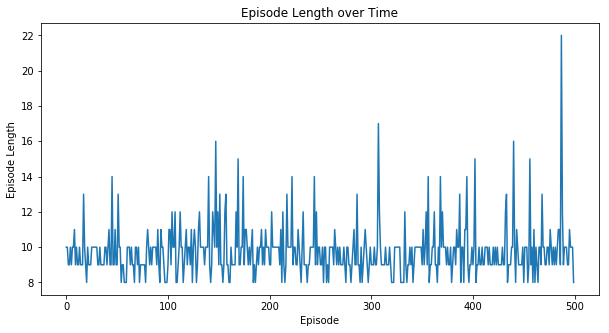

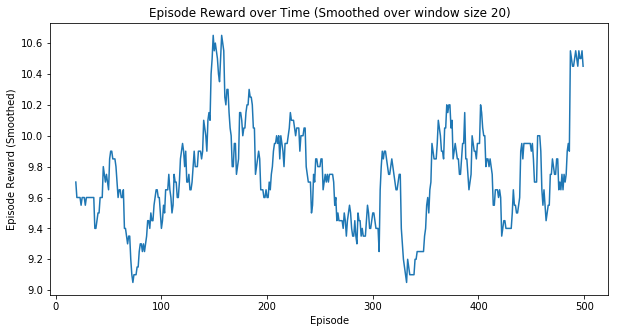

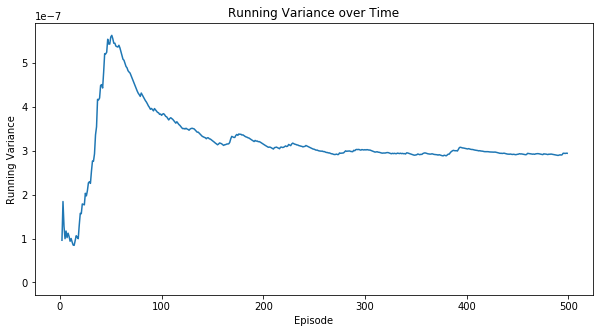

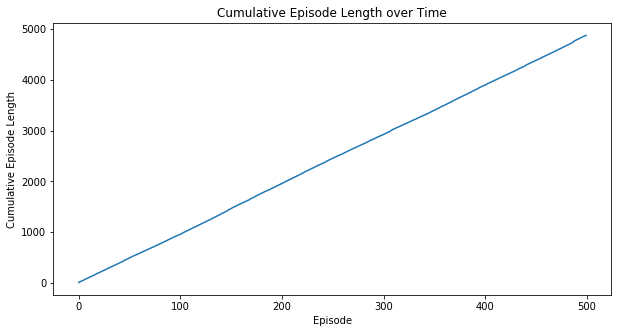

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [23]:
plotting.plot_pgresults(stats)